# MODNet 'matbench_dielectric' benchmarking

In [43]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [44]:
from IPython.display import Markdown
Markdown(filename="./README.md")

# MODNet matbench benchmarks

## Interim results

| Dataset   | Structure? |    Best result (MODNet)      | Dataset size |
|:----------|:----------:|-----------------------------:|-------------:|
| steels    |      x     | 95.2 [Automatminer] (120)    |      312     |
| JDFT2D    |            | 38.6 [Automatminer] (32.7)   |      636     |
| PhDOS     |            | 36.9 [MEGNet] (38.7)         |     1265     |
| Band gap  |      x     | 0.42 [Automatminer] (0.37)   |     4604     |
| *n*       |            | 0.30 [Automatminer] (-)      |     4764     |
| log G     |            | 0.085 [Automatminer] (-)     |   10987      |
| log K     |            | 0.085 [Automatminer] (-)     |   10987      |

## To-discuss

- Feature selection inside NCV, 
    - Will be expensive, so could also just subsample
    - Some datasets hang when doing NMI; need to split it up
- Investigate feature importance vs selected features
    - Second feature often poor
    - More important for composition-only datasets
    - Could also include new matminer sets 
    - Should benchmark at least one other feature selection method
- Training is *very* variable
    - General rules for overfitting: often validation set error > 3 * test set error
    - Relatively large spread between folds
    - Need to investigate dropout/regularisation
    - Learning rate schemes: currently halving but could do high -> short tuning
- Output scaling



## Data exploration

In [2]:
df = load_dataset("matbench_dielectric")
# df["composition"] = df["composition"].map(Composition)

Fetching matbench_dielectric.json.gz from https://ml.materialsproject.org/projects/matbench_dielectric.json.gz to /home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/datasets/matbench_dielectric.json.gz


In [3]:
df.columns

Index(['structure', 'n'], dtype='object')

### Target space

In [5]:
df.describe()

,n
count,4764.000000
mean,2.428314
std,2.101722
min,1.000000
25%,1.684573
50%,2.060778
75%,2.595320
max,62.062998


Text(0.5, 0, 'n')

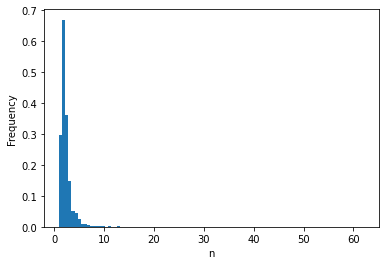

In [6]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["n"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("n")

## Featurization and feature selection

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
PRECOMPUTED_MODDATA = "./precomputed/dielectric_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_dielectric")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["n"].tolist(), 
        target_names=["n"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATA)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f2d308d2ee0> object, created with modnet version 0.1.8~develop


## Training

In [4]:
data.feature_selection(n=1500, use_precomputed_cross_nmi=True)

INFO:root:Loading cross NMI from 'Features_cross' file.
INFO:root:Downloading featurized dataset MP_2018.6_CROSS_NMI from https://ndownloader.figshare.com/files/25584803 into /home/users/m/e/mevans/src/modnet/modnet/data/Features_cross


INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...
INFO:root:Computing optimal features...
INFO:root:Selected 50/1101 features...
INFO:root:Selected 100/1101 features...
INFO:root:Selected 150/1101 features...
INFO:root:Selected 200/1101 features...
INFO:root:Selected 250/1101 features...
INFO:root:Selected 300/1101 features...
INFO:root:Selected 350/1101 features...
INFO:root:Selected 400/1101 features...
INFO:root:Selected 450/1101 features...
INFO:root:Selected 500/1101 features...
INFO:root:Selected 550/1101 features...
INFO:root:Selected 600/1101 features...
INFO:root:Selected 650/1101 features...
INFO:root:Selected 700/1101 features...
INFO:root:Selected 750/1101 features...
INFO:root:Selected 800/1101 features...
INFO:root:Selected 850/1101 features...
INFO:root:Selected 900/1101 features...
INFO:root:Selected 950/1101 features...
INFO:root:Selected 1000/1101 features...
INFO:root:Selected 1050/1101 features...
INFO:root:Se

In [67]:
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
try:
    matbench_benchmark
except:
    os.chdir("/home/modl/mevans/repos/modnet-matbench/")
    from modnet_matbench.utils import matbench_benchmark


best_settings = {
    "num_neurons": [[128], [32], [8], [8]],
    "n_feat": 512,
    "lr": 0.005,
    "epochs": 1000,
    "verbose": 0,
    "act": "relu",
    "batch_size": 64,
    "loss": "mae",
}

results = matbench_benchmark(data, [[["n"]]], {"n": 1}, best_settings)

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: MAE = 0.20772303124182578


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: MAE = 0.2958797260240194


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: MAE = 0.45047667139959513


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: MAE = 0.3097324733472022
Model #5: MAE = 0.36272902819931285
Overall MAE = 0.3253081860423911


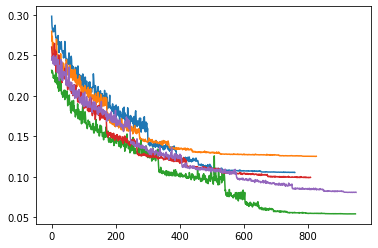

In [68]:
for i in range(5):
    plt.plot(results["models"][i].history.history["loss"][50:])

In [69]:
import seaborn as sns
reg_df = pd.DataFrame(
    np.array([
        [x for targ in results["targets"] for x in targ],
        [y for pred in results["predictions"] for y in pred],
        [e for err in results["errors"] for e in err]
    ]).T,
    columns=["targets", "predictions", "errors"]
)
splits = []
for i in range(5):
    for j in range(len(results["targets"][i])):
        splits.append(i)
reg_df["split"] = splits

Text(0, 0.5, 'Pred.')

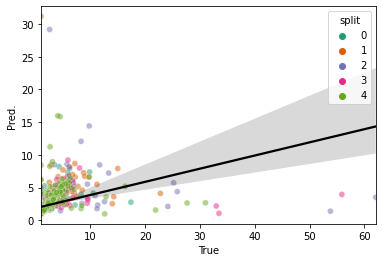

In [70]:
fig, ax = plt.subplots()
#ax.set_aspect("equal")
sns.scatterplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", ax=ax, alpha=0.5)
sns.regplot(data=reg_df, x="targets", y="predictions", ax=ax, scatter=False, color="k")
# plt.plot(*ax.get_xlim(), *ax.get_xlim(), c="k",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Pred.")

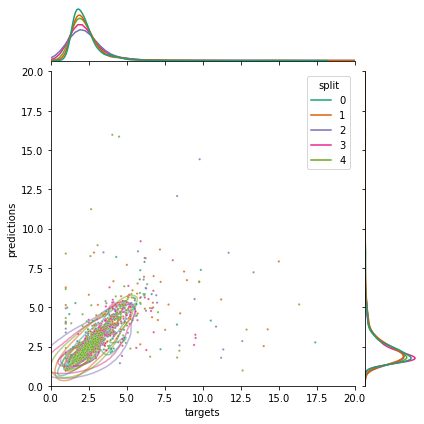

In [71]:
g = sns.jointplot(
    data=reg_df, 
    x="targets", 
    y="predictions", 
    hue="split", 
    palette="Dark2", 
    alpha=0.0, 
    marginal_kws={"shade": False}, 
    xlim=(0, 20), 
    ylim=(0, 20)
)
g.plot_joint(sns.scatterplot, hue=None, c="black", s=5, alpha=0.8)
g.plot_joint(sns.kdeplot, color="split", zorder=0, levels=5, alpha=0.5)